<a href="https://colab.research.google.com/github/vkk1710/Def_classifier/blob/master/sos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random
import shutil
import cv2
import zipfile
import torch.optim as optim
import torch
import torchvision.transforms as transforms

In [0]:
zipf = zipfile.ZipFile('/content/Def_class.zip','r')
zipf.extractall('/content/data')
zipf.close()

In [4]:
os.listdir('/content/data/Def_class')  #size of the crops in the dataset = 32x32

['healthy_leaves', 'Defective_leaves']

In [0]:
ttr = transforms.Compose([
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
tte = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [6]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.dep1 = nn.Conv2d(3,3,3,groups = 3)
        self.point1 = nn.Conv2d(3,16,1)
        self.dep2 = nn.Conv2d(16,16,3,groups = 16)
        self.point2 = nn.Conv2d(16,32,1)
        self.dep3 = nn.Conv2d(32,32,3,groups = 32)
        self.point3 = nn.Conv2d(32,64,1)
        #self.con3 = nn.Conv2d(64,32,3)
        self.pool = nn.MaxPool2d(2,2)
        self.lin1 = nn.Linear(256,256)
        self.lin2 = nn.Linear(256,2)
    def forward(self,x):
        x = self.point1(self.dep1(x))
        x = self.pool(F.relu(x))
        x = self.point2(self.dep2(x))
        x = self.pool(F.relu(x))
        x = self.point3(self.dep3(x))
        x = self.pool(F.relu(x))
        #x = self.pool(F.relu(self.con3(x)))
        x = x.view(-1,256)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.softmax(x,dim=1)
mod = cnn().to(device)   

In [8]:
import numpy as np
total_params = 0
for parameter in mod.parameters():
  if parameter.requires_grad:
    total_params += np.prod(parameter.size())
print('total_params:', total_params)

total_params: 69536


In [0]:
import torchvision.datasets as datasets
from sklearn.model_selection import KFold
data = datasets.ImageFolder('/content/data/Def_class',transform = ttr)
kf = KFold(n_splits=5, shuffle=True)

In [0]:
t=[]
v=[]
for j, (train_index, test_index) in enumerate(kf.split(data)):
    train = torch.utils.data.Subset(data, train_index)
    test = torch.utils.data.Subset(data, test_index)    
    #print(len(train))
    train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
    t.append(train_loader)
    v.append(val_loader)

In [11]:
train_acc=[]

for j,train_loader in enumerate(t):   
    tot_loss = 0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mod.parameters(), lr=0.001)
    
    ## Training 
    print(j,'th split-----------')
    for epochs in range(3):

        for i,data in enumerate(train_loader):
            inp,label = data
            inp,label = inp.to(device),label.to(device)
            optimizer.zero_grad()
            out = mod(inp)
            loss = criterion(out,label)
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            if i%288 == 287 :
                print('epochs : {},batch : {} = loss : {}'.format(epochs,i+1,tot_loss/288))
                tot_loss = 0
        
    correct = 0
    tot = 0
    print('Train accuracy calculating..............')
    with torch.no_grad():
        for data in train_loader:
            inp,lab = data
            inp,lab = inp.to(device),lab.to(device)
            out = mod(inp)
            #print(out)
            #print(lab)
            for i in range(out.shape[0]):
                tot += 1
                if out[i].argmax() == lab[i]:
                    #print(out[i].argmax(),lab[i])
                    correct+=1
    print('Split - ',j)
    print('correct : ',correct)        
    print('total : ',tot)
    acc = correct/tot * 100
    train_acc.append(acc)
    print('train_accuracy : ',acc)
    

0 th split-----------
epochs : 0,batch : 288 = loss : 0.5040912672670351
epochs : 1,batch : 288 = loss : 0.3896736530587077
epochs : 2,batch : 288 = loss : 0.37511792230523294
Train accuracy calculating..............
Split -  0
correct :  8386
total :  9187
train_accuracy :  91.28115815826712
1 th split-----------
epochs : 0,batch : 288 = loss : 0.3591211905909909
epochs : 1,batch : 288 = loss : 0.3496448954360353
epochs : 2,batch : 288 = loss : 0.3491860668485363
Train accuracy calculating..............
Split -  1
correct :  8952
total :  9187
train_accuracy :  97.44203766191357
2 th split-----------
epochs : 0,batch : 288 = loss : 0.34470310372610885
epochs : 1,batch : 288 = loss : 0.3406517654657364
epochs : 2,batch : 288 = loss : 0.3408346807377206
Train accuracy calculating..............
Split -  2
correct :  8936
total :  9187
train_accuracy :  97.2678785240013
3 th split-----------
epochs : 0,batch : 288 = loss : 0.3363343852882584
epochs : 1,batch : 288 = loss : 0.3392305781857

In [12]:
test_acc = []
correct = 0
tot = 0
print('Test accuracy calculating..............')
for j,val_loader in enumerate(v):    
    with torch.no_grad():
        for data in val_loader:
            inp,lab = data
            inp,lab = inp.to(device),lab.to(device)
            out = mod(inp)
            #print(out)
            #print(lab)
            for i in range(out.shape[0]):
                tot += 1
                if out[i].argmax() == lab[i]:
                    #print(out[i].argmax(),lab[i])
                    correct+=1
    print('Split - ',j)
    print('correct : ',correct)        
    print('total : ',tot)
    acc = correct/tot * 100
    test_acc.append(acc)
    print('test_accuracy : ',acc)

Test accuracy calculating..............
Split -  0
correct :  2202
total :  2297
test_accuracy :  95.86417065737919
Split -  1
correct :  4426
total :  4594
test_accuracy :  96.34305616020897
Split -  2
correct :  6644
total :  6891
test_accuracy :  96.41561456972863
Split -  3
correct :  8855
total :  9188
test_accuracy :  96.37570744449282
Split -  4
correct :  11076
total :  11484
test_accuracy :  96.44723092998954


In [13]:
import statistics
print('final_train_acc = ',statistics.mean(train_acc))
print('final_test_acc = ',statistics.mean(test_acc))

final_train_acc =  96.20558265524352
final_test_acc =  96.28915595235983


In [0]:
torch.save(mod.state_dict(), '/content/weights_32_mod.pt')

# **Obj.localization**

In [15]:
img = cv2.imread('/content/img.JPG')
#print(img)
img.shape

(256, 256, 3)

In [0]:
cen=[]
for i in range(8):
    for j in range(8):
        l=[]
        l.append(16+32*i)
        l.append(16+32*j)
        cen.append(l)

In [0]:
anchor = [[25,25]]

In [0]:
import torchvision.transforms as transforms
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [0]:
import matplotlib.pyplot as plt
defe = []
i=0
with torch.no_grad():
    for an in anchor:
        for c in cen:
            i = i+1
            stx = c[0]-an[0]//2
            edx = c[0]+an[0]//2
            sty = c[1]-an[1]//2
            edy = c[1]+an[1]//2
            tar = img[stx:edx,sty:edy]
            #print(tar.shape)
            tar = trans(tar)
            out = mod(tar.view(1,3,32,32).to(device))
            out
            if(out[0][0].item() >= 0.85):
                cv2.rectangle(img,(stx,sty),(edx,edy),(255,0,0),1)
                defe.append([an,c])
           

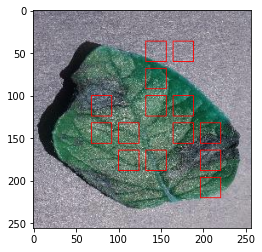

In [22]:
plt.imshow(img)

In [23]:
cv2.imwrite(os.path.join('/content','img1.jpg'),img)

True